Ignacio Vellido Expósito

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Ejercicios
<ol>
    <li> Aplicar sobre la base de datos "dogs and cats" el proceso aprendido usando como modelo base VGG16, MobileNetV2, ResNet50, ResNet101, InceptionV3 (GoogleNet).
    <li> Aplicar sobre la base de datos <a link="mask_face.zip">"mask_face"</a> el proceso aprendido usando algunos de los modelos base VGG16, MobileNetV2, ResNet50, ResNet101, InceptionV3 (GoogleNet).
</ol>
Analizar los resultados obtenidos mostrando tablas, gráficas y conclusiones sobre la agudeza en resultados y eficiencia computacional. 

**Conclusiones**: La red Inception con los pesos de ImageNet es lo suficientemente potente para tratar los dos datasets de esta práctica. Somos capaces de alcanzar 93% y 95% de accuracy con mínimo esfuerzo computacional, y 95% y 100% tras unas pocas épocas de fine tuning.

Por contra, el tamaño de memoria requerido para estos modelos es enorme. Por ejemplo, para el dataset "mask_face" se acaban utilizando 2.69GB de memoria.

In [2]:
################################################################################
# Libraries
################################################################################

import tensorflow_datasets as tfds

# Import layers
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation
from tensorflow.keras.layers.experimental.preprocessing import RandomZoom

################################################################################

import cv2

# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Aplicar sobre la base de datos "dogs and cats" el proceso aprendido usando como modelo base VGG16, MobileNetV2, ResNet50, ResNet101, InceptionV3 (GoogleNet).

In [ ]:
################################################################################
# Load data
################################################################################

#tfds.disable_progress_bar()
# No usamos toda la base de datos solamente el 60%
(train_ds, validation_ds, test_ds), metadata = tfds.load(
    "cats_vs_dogs",
    # 10% para validación 10% para test 
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    with_info=True,
    as_supervised=True  # cargamos las etiquetas
)

print("Imágenes para el entrenamiento: %d" % tf.data.experimental.cardinality(train_ds))
print("Imágenes para la validación: %d" % tf.data.experimental.cardinality(validation_ds))
print("Imagenes para el test: %d" % tf.data.experimental.cardinality(test_ds))

num_classes = metadata.features['label'].num_classes
print(num_classes)

Imágenes para el entrenamiento: 9305
Imágenes para la validación: 2326
Imagenes para el test: 2326
2


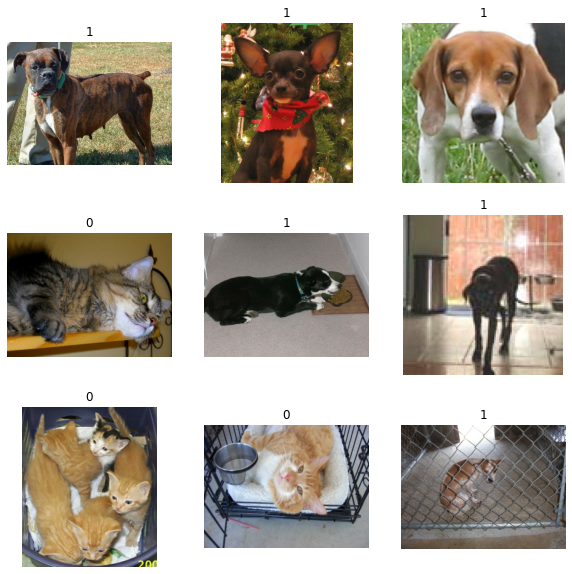

In [ ]:
################################################################################
# Visualize data
################################################################################
plt.figure(figsize=(10, 10))

for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

#Label=1 dot label=0 cat

In [ ]:
################################################################################
# Preprocess data
################################################################################

size = (150, 150)

train_ds      = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds       = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))


batch_size = 32
#la primera vez que se itera sobre la base de datos se pone en cache.
#en las siguientes iteraciones se tomarán los datos de la cache.
#creamos lotes de tamaño batch_size
#prefetch permite preparar los siguientes elementos mientras 
#que estan siendo procesaods los actuales elementos. 
train_ds      = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds       = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

In [ ]:
################################################################################
# Define model
################################################################################

# Normalizamos al rango [-1,1]
# usando outputs = (inputs - mean) / sqrt(var)
mean = np.array([127.5] * 3)
var = mean ** 2

# Input layer
input = Input(shape=(150, 150, 3))

# Data augmentation
x = RandomFlip("horizontal_and_vertical")(input)
x = RandomRotation(0.4)(x)

# Normalización
x = Normalization(mean=mean, variance=var)(x)

base_model = tf.keras.applications.InceptionV3(
    weights="imagenet",  # Cargamos los pesos entrenados con ImageNet.
    input_shape=(150, 150, 3), #por defecto acepta 299x299x3
    include_top=False,#Las primer capa  no se incluye
)

# Congelamos 
base_model.trainable = False

x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)

output = Dense(1)(x)

model = Model(input, output)
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
random_flip_4 (RandomFlip)   (None, 150, 150, 3)       0         
_________________________________________________________________
random_rotation_4 (RandomRot (None, 150, 150, 3)       0         
_________________________________________________________________
normalization_4 (Normalizati (None, 150, 150, 3)       7         
_________________________________________________________________
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0   

In [ ]:
################################################################################
# Fit model
################################################################################

# Parameters
epochs = 50

# Compile model
opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

# EarlyStopping callback
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', 
                                                  patience=5,
                                                  restore_best_weights=True)

# Fitting
history = model.fit(train_ds,
                    validation_data=validation_ds,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    callbacks=[early_callback],
                    verbose=1
          )

Epoch 1/50
291/291 [==============================] - 19s 51ms/step - loss: 5.7367 - binary_accuracy: 0.5932 - val_loss: 1.3722 - val_binary_accuracy: 0.8921
Epoch 2/50
291/291 [==============================] - 14s 47ms/step - loss: 3.3975 - binary_accuracy: 0.7542 - val_loss: 0.9736 - val_binary_accuracy: 0.9243
Epoch 3/50
291/291 [==============================] - 14s 48ms/step - loss: 3.7686 - binary_accuracy: 0.7381 - val_loss: 1.3212 - val_binary_accuracy: 0.9041
Epoch 4/50
291/291 [==============================] - 14s 48ms/step - loss: 3.2074 - binary_accuracy: 0.7773 - val_loss: 1.2195 - val_binary_accuracy: 0.9132
Epoch 5/50
291/291 [==============================] - 14s 49ms/step - loss: 5.1054 - binary_accuracy: 0.6563 - val_loss: 4.2088 - val_binary_accuracy: 0.7072
Epoch 6/50
291/291 [==============================] - 14s 49ms/step - loss: 4.8931 - binary_accuracy: 0.6700 - val_loss: 1.2145 - val_binary_accuracy: 0.9140
Epoch 7/50
291/291 [==============================] 

Clase predicha [0]


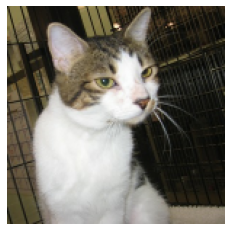

In [ ]:
################################################################################
# Make predictions
################################################################################

y_prob = model.predict(test_ds) 
y_classes = (y_prob > 0.5)*1

print('Clase predicha',y_classes[0])
for images, label in test_ds.take(1):
    plt.figure(figsize=(4, 4))
    first_image = images[0]
    plt.imshow(first_image.numpy().astype("int32"))
    plt.axis("off")

In [ ]:
################################################################################
# Test model
################################################################################

score = model.evaluate(test_ds) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

73/73 [==============================] - 3s 39ms/step - loss: 1.0076 - binary_accuracy: 0.9304
Test loss: 1.007593035697937
Test accuracy: 0.930352509021759


In [ ]:
################################################################################
# Fine tuning
################################################################################

# Descongelamos el modelo base
base_model.trainable = True

model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
random_flip_4 (RandomFlip)   (None, 150, 150, 3)       0         
_________________________________________________________________
random_rotation_4 (RandomRot (None, 150, 150, 3)       0         
_________________________________________________________________
normalization_4 (Normalizati (None, 150, 150, 3)       7         
_________________________________________________________________
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0   

In [ ]:
# Parameters
epochs = 25
lr = 1e-5

# Compile model
opt = tf.keras.optimizers.Adam(
        lr=lr, 
      )
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

# EarlyStopping callback
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', 
                                                  patience=5,
                                                  restore_best_weights=True)

# Fitting
history = model.fit(train_ds,
                    validation_data=validation_ds,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    callbacks=[early_callback]
          )

# Evaluate
y_prob = model.predict(test_ds) 
y_classes = (y_prob > 0.5)*1
score = model.evaluate(test_ds) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Epoch 1/25
291/291 [==============================] - 48s 139ms/step - loss: 2.7185 - binary_accuracy: 0.8159 - val_loss: 0.6816 - val_binary_accuracy: 0.9544
Epoch 2/25
291/291 [==============================] - 38s 132ms/step - loss: 2.2395 - binary_accuracy: 0.8480 - val_loss: 1.1551 - val_binary_accuracy: 0.9226
Epoch 3/25
291/291 [==============================] - 39s 134ms/step - loss: 4.6956 - binary_accuracy: 0.6897 - val_loss: 6.9711 - val_binary_accuracy: 0.5477
Epoch 4/25
291/291 [==============================] - 39s 135ms/step - loss: 7.5250 - binary_accuracy: 0.5120 - val_loss: 1.4348 - val_binary_accuracy: 0.9028
Epoch 5/25
291/291 [==============================] - 40s 136ms/step - loss: 3.9520 - binary_accuracy: 0.7383 - val_loss: 7.6199 - val_binary_accuracy: 0.4996
Epoch 6/25
73/73 [==============================] - 3s 40ms/step - loss: 0.5825 - binary_accuracy: 0.9592
Test loss: 0.5824857950210571
Test accuracy: 0.9591573476791382


Aplicar sobre la base de datos "mask_face" el proceso aprendido usando algunos de los modelos base VGG16, MobileNetV2, ResNet50, ResNet101, InceptionV3 (GoogleNet).

In [44]:
################################################################################
# Load data
################################################################################

# https://www.tensorflow.org/tutorials/load_data/images

img_shape = (270,180)
batch_size = 32

train_df = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/data",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_shape,
    batch_size=batch_size
)

test_df = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/data",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_shape,
    batch_size=batch_size
)

print(train_df.class_names)

Found 1376 files belonging to 2 classes.
Using 1101 files for training.
Found 1376 files belonging to 2 classes.
Using 275 files for validation.
['with_mask', 'without_mask']


<Figure size 720x720 with 0 Axes>

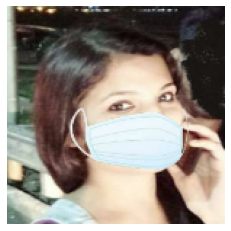

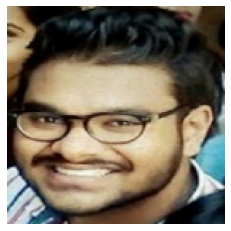

In [35]:
################################################################################
# Visualize data
################################################################################
plt.figure(figsize=(10, 10))

for image, label in train_df.take(1):
    plt.figure(figsize=(4, 4))
    plt.imshow(images[0].numpy().astype("int32"))
    plt.axis("off")
    plt.show()

    plt.imshow(images[1].numpy().astype("int32"))
    plt.axis("off")
    plt.show()

In [45]:
################################################################################
# Preprocess data
################################################################################

size = (150, 150)

train_df = train_df.map(lambda x, y: (tf.image.resize(x, size), y))
test_df  = test_df.map(lambda x, y: (tf.image.resize(x, size), y))

# Get validation split
def is_test(x, y):
    return x % 5 == 0

def is_train(x, y):
    return not is_test(x, y)

recover = lambda x,y: y

val_df = train_df.enumerate() \
                    .filter(is_test) \
                    .map(recover)

train_df = train_df.enumerate() \
                    .filter(is_train) \
                    .map(recover)

In [46]:
################################################################################
# Define model
################################################################################

# Normalizamos al rango [-1,1]
# usando outputs = (inputs - mean) / sqrt(var)
mean = np.array([127.5] * 3)
var = mean ** 2

# Input layer
input = Input(shape=(150, 150, 3))

# Existe cierto data augmentation en el dataset, pero no en todas las imágenes
x = RandomFlip("horizontal_and_vertical")(input)
x = RandomRotation(0.4)(x)

# Normalización
x = Normalization(mean=mean, variance=var)(x)

base_model = tf.keras.applications.InceptionV3(
    weights="imagenet",  # Cargamos los pesos entrenados con ImageNet.
    input_shape=(150, 150, 3), #por defecto acepta 299x299x3
    include_top=False,#Las primer capa  no se incluye
)

# Congelamos 
base_model.trainable = False

x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)

output = Dense(1)(x)

model = Model(input, output)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
random_flip_2 (RandomFlip)   (None, 150, 150, 3)       0         
_________________________________________________________________
random_rotation_2 (RandomRot (None, 150, 150, 3)       0         
_________________________________________________________________
normalization_2 (Normalizati (None, 150, 150, 3)       7         
_________________________________________________________________
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0   

In [47]:
################################################################################
# Fit model
################################################################################

# Parameters
epochs = 50

# Compile model
opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

# EarlyStopping callback
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', 
                                                  patience=5,
                                                  restore_best_weights=True)

# Fitting
history = model.fit(train_df,
                    validation_data=val_df,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    callbacks=[early_callback],
                    verbose=1
          )

Epoch 1/50
28/28 [==============================] - 13s 295ms/step - loss: 6.6846 - binary_accuracy: 0.5236 - val_loss: 3.9732 - val_binary_accuracy: 0.6875
Epoch 2/50
28/28 [==============================] - 8s 249ms/step - loss: 3.2532 - binary_accuracy: 0.7280 - val_loss: 2.0402 - val_binary_accuracy: 0.8080
Epoch 3/50
28/28 [==============================] - 8s 256ms/step - loss: 1.6894 - binary_accuracy: 0.8458 - val_loss: 0.7925 - val_binary_accuracy: 0.9286
Epoch 4/50
28/28 [==============================] - 8s 252ms/step - loss: 2.3580 - binary_accuracy: 0.8129 - val_loss: 0.2400 - val_binary_accuracy: 0.9688
Epoch 5/50
28/28 [==============================] - 8s 252ms/step - loss: 1.2395 - binary_accuracy: 0.8978 - val_loss: 0.4368 - val_binary_accuracy: 0.9554
Epoch 6/50
28/28 [==============================] - 8s 249ms/step - loss: 1.1498 - binary_accuracy: 0.8976 - val_loss: 1.6530 - val_binary_accuracy: 0.8661
Epoch 7/50
28/28 [==============================] - 8s 251ms/st

Clase predicha [1]


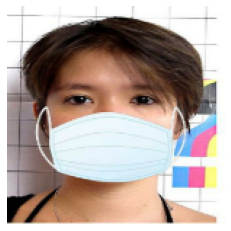

In [48]:
################################################################################
# Make predictions
################################################################################

y_prob = model.predict(test_df) 
y_classes = (y_prob > 0.5)*1

print('Clase predicha',y_classes[0])
for images, label in test_df.take(1):
    plt.figure(figsize=(4, 4))
    first_image = images[0]
    plt.imshow(first_image.numpy().astype("int32"))
    plt.axis("off")

In [49]:
################################################################################
# Test model
################################################################################

score = model.evaluate(test_df) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

9/9 [==============================] - 1s 54ms/step - loss: 0.1783 - binary_accuracy: 0.9818
Test loss: 0.17830920219421387
Test accuracy: 0.9818181991577148


In [50]:
################################################################################
# Fine tuning
################################################################################

# Descongelamos el modelo base
base_model.trainable = True

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
random_flip_2 (RandomFlip)   (None, 150, 150, 3)       0         
_________________________________________________________________
random_rotation_2 (RandomRot (None, 150, 150, 3)       0         
_________________________________________________________________
normalization_2 (Normalizati (None, 150, 150, 3)       7         
_________________________________________________________________
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0   

In [51]:
# Parameters
epochs = 25
lr = 1e-5

# Compile model
opt = tf.keras.optimizers.Adam(
        lr=lr, 
      )
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

# EarlyStopping callback
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', 
                                                  patience=5,
                                                  restore_best_weights=True)

# Fitting
history = model.fit(train_df,
                    validation_data=val_df,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    callbacks=[early_callback]
          )

# Evaluate
y_prob = model.predict(test_df) 
y_classes = (y_prob > 0.5)*1
score = model.evaluate(test_df) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Epoch 1/25
28/28 [==============================] - 16s 366ms/step - loss: 0.5630 - binary_accuracy: 0.9472 - val_loss: 0.0000e+00 - val_binary_accuracy: 1.0000
Epoch 2/25
28/28 [==============================] - 9s 309ms/step - loss: 0.3539 - binary_accuracy: 0.9729 - val_loss: 0.0681 - val_binary_accuracy: 0.9955
Epoch 3/25
28/28 [==============================] - 9s 307ms/step - loss: 0.1129 - binary_accuracy: 0.9898 - val_loss: 0.0000e+00 - val_binary_accuracy: 1.0000
Epoch 4/25
28/28 [==============================] - 9s 308ms/step - loss: 0.1882 - binary_accuracy: 0.9826 - val_loss: 0.0681 - val_binary_accuracy: 0.9955
Epoch 5/25
28/28 [==============================] - 9s 312ms/step - loss: 0.4599 - binary_accuracy: 0.9679 - val_loss: 0.0689 - val_binary_accuracy: 0.9955
Epoch 6/25
9/9 [==============================] - 1s 41ms/step - loss: 0.0000e+00 - binary_accuracy: 1.0000
Test loss: 0.0
Test accuracy: 1.0
